**Importok és alapbeállítások**

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import json
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

TF version: 2.18.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Konfiguráció + mappák**

In [3]:
DATASET_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "val")
TEST_DIR = os.path.join(DATASET_DIR, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_INITIAL = 6
EPOCHS_FINE = 6
SEED = 42

#output dir
OUT_ROOT = "/kaggle/working"
FIG_DIR = os.path.join(OUT_ROOT, "figures")
MET_DIR = os.path.join(OUT_ROOT, "metrics")
MODEL_DIR = os.path.join(OUT_ROOT, "models")

os.makedirs(FIG_DIR, exist_ok = True)
os.makedirs(MET_DIR, exist_ok = True)
os.makedirs(MODEL_DIR, exist_ok = True)

**Adatgenerátorok + betöltés**

In [4]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.06,
    height_shift_range = 0.06,
    horizontal_flip = True
)

val_test_datagen = ImageDataGenerator(rescale = 1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    seed = SEED
)

val_gen = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    seed = SEED
)

test_gen = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    shuffle = False
)

print("Class indices:", train_gen.class_indices)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


**Class weight**

In [5]:
counts = np.bincount(train_gen.classes)
total = counts.sum()
class_weight = {0: total/(2*counts[0]), 1: total/(2*counts[1])}
print("Train class counts:", counts, "class_weight:", class_weight)

Train class counts: [1341 3875] class_weight: {0: 1.9448173005219984, 1: 0.6730322580645162}


**Modell**

In [6]:
base = DenseNet121(
    weights = "imagenet",
    include_top = False,
    input_tensor = Input(shape=(224, 224, 3))
)

#backbone fagyasztas
for layer in base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(256, activation = "relu")(x)
x = Dropout(0.5)(x)
out = Dense(1, activation = "sigmoid")(x)

model = Model(inputs = base.input, outputs = out)

model.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

model.summary()

I0000 00:00:1766929674.548706      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

**Callbackek + checkpoint**

In [7]:
ckpt_path = os.path.join(MODEL_DIR, "densenet121_best.keras")
callbacks = [
    EarlyStopping(monitor = "val_loss", patience = 3, restore_best_weights = True),
    ReduceLROnPlateau(monitor = "val_loss", factor = 0.3, patience = 2, min_lr = 1e-7),
    ModelCheckpoint(ckpt_path, monitor = "val_loss", save_best_only = True)
]

**Tanítás - elsőnek csak a head**

In [8]:
history1 = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = EPOCHS_INITIAL,
    callbacks = callbacks,
    class_weight = class_weight
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1766929980.102766    2098 service.cc:148] XLA service 0x79a2ac002ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766929980.103533    2098 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766929982.852231    2098 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/163 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.5078 - loss: 0.8286    

I0000 00:00:1766929993.189974    2098 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 166s 867ms/step - accuracy: 0.7083 - loss: 0.5531 - val_accuracy: 0.7500 - val_loss: 0.3812 - learning_rate: 1.0000e-04
Epoch 2/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 548ms/step - accuracy: 0.8948 - loss: 0.2654 - val_accuracy: 0.8125 - val_loss: 0.3297 - learning_rate: 1.0000e-04
Epoch 3/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 545ms/step - accuracy: 0.9122 - loss: 0.2186 - val_accuracy: 0.7500 - val_loss: 0.3505 - learning_rate: 1.0000e-04
Epoch 4/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 542ms/step - accuracy: 0.9262 - loss: 0.1931 - val_accuracy: 0.7500 - val_loss: 0.3436 - learning_rate: 1.0000e-04
Epoch 5/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 550ms/step - accuracy: 0.9333 - loss: 0.1762 - val_accuracy: 0.8125 - val_loss: 0.2926 - learning_rate: 3.0000e-05
Epoch 6/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 544ms/step - accuracy: 0.9253 - loss: 0.1787 - val_accuracy: 0.8125 - val_loss: 0.3114 - learning_rate: 3.0000e-05


**Fine-tune**

In [10]:
for layer in base.layers[-50:]:
    layer.trainable = True

model.compile(
    optimizer = Adam(learning_rate = 1e-5),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

history2 = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = EPOCHS_FINE,
    callbacks = callbacks,
    class_weight = class_weight
)

Epoch 1/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 132s 615ms/step - accuracy: 0.9082 - loss: 0.3261 - val_accuracy: 0.8125 - val_loss: 0.2816 - learning_rate: 1.0000e-05
Epoch 2/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 556ms/step - accuracy: 0.9194 - loss: 0.1947 - val_accuracy: 0.8750 - val_loss: 0.2533 - learning_rate: 1.0000e-05
Epoch 3/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 558ms/step - accuracy: 0.9331 - loss: 0.1606 - val_accuracy: 0.8750 - val_loss: 0.2271 - learning_rate: 1.0000e-05
Epoch 4/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 554ms/step - accuracy: 0.9285 - loss: 0.1805 - val_accuracy: 0.9375 - val_loss: 0.2021 - learning_rate: 1.0000e-05
Epoch 5/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 558ms/step - accuracy: 0.9436 - loss: 0.1515 - val_accuracy: 1.0000 - val_loss: 0.1753 - learning_rate: 1.0000e-05
Epoch 6/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 575ms/step - accuracy: 0.9482 - loss: 0.1343 - val_accuracy: 1.0000 - val_loss: 0.1419 - learning_rate: 1.0000e-05


**Görbék mentése**

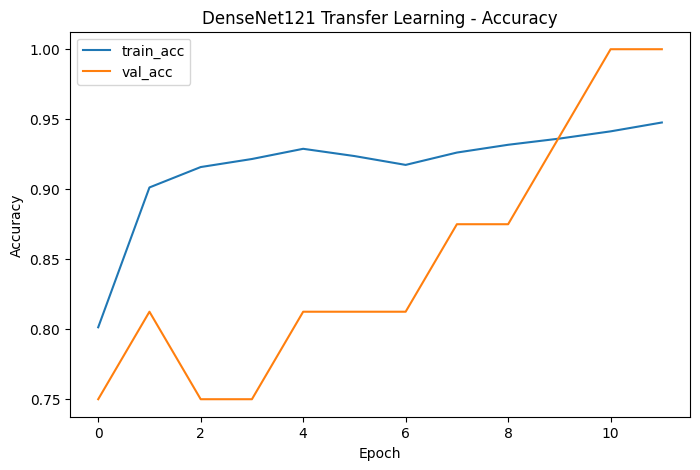

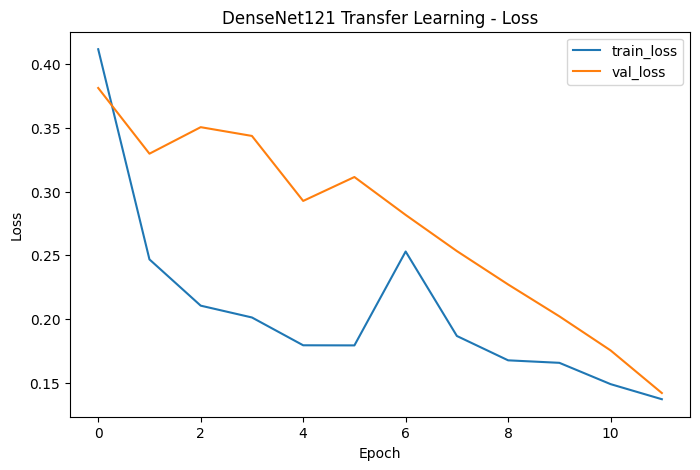

Saved: /kaggle/working/figures/densenet121_accuracy.png
Saved: /kaggle/working/figures/densenet121_loss.png


In [11]:
def merge_histories(h1, h2):
    merged = {}
    for k in h1.history.keys():
        merged[k] = h1.history[k] + h2.history[k]
    return merged

hist = merge_histories(history1, history2)

# Accuracy
plt.figure(figsize=(8,5))
plt.plot(hist["accuracy"], label="train_acc")
plt.plot(hist["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("DenseNet121 Transfer Learning - Accuracy")
plt.legend()
acc_path = os.path.join(FIG_DIR, "densenet121_accuracy.png")
plt.savefig(acc_path, dpi=150, bbox_inches="tight")
plt.show()

# Loss
plt.figure(figsize=(8,5))
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("DenseNet121 Transfer Learning - Loss")
plt.legend()
loss_path = os.path.join(FIG_DIR, "densenet121_loss.png")
plt.savefig(loss_path, dpi=150, bbox_inches="tight")
plt.show()

print("Saved:", acc_path)
print("Saved:", loss_path)

**Teszt kiértékelés + metrikák mentése**

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 834ms/step
              precision    recall  f1-score   support

      NORMAL       0.88      0.84      0.86       234
   PNEUMONIA       0.91      0.93      0.92       390

    accuracy                           0.90       624
   macro avg       0.89      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624



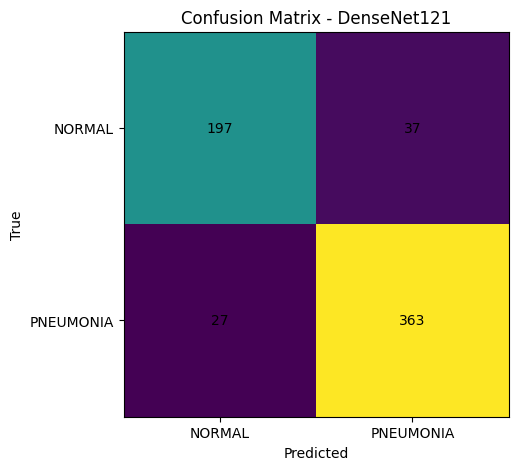

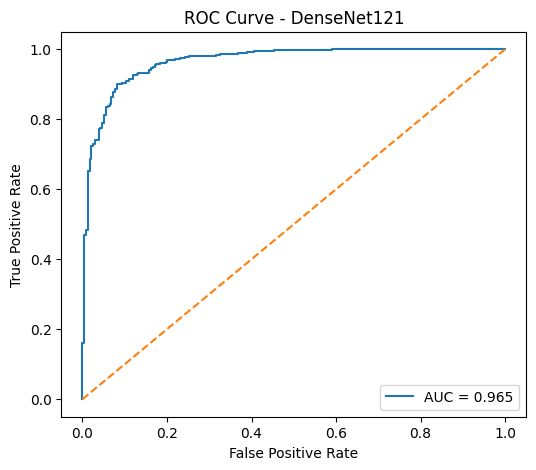

Saved: /kaggle/working/figures/densenet121_confusion_matrix.png
Saved: /kaggle/working/figures/densenet121_roc.png
Saved: /kaggle/working/metrics/densenet121_metrics.json


In [12]:
model.load_weights(ckpt_path)

test_gen.reset()
y_prob = model.predict(test_gen).ravel()
y_pred = (y_prob >= 0.5).astype(int)
y_true = test_gen.classes

print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

report = classification_report(
    y_true, y_pred,
    target_names=["NORMAL", "PNEUMONIA"],
    output_dict=True
)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5.5,5))
plt.imshow(cm)
plt.title("Confusion Matrix - DenseNet121")
plt.xticks([0,1], ["NORMAL", "PNEUMONIA"])
plt.yticks([0,1], ["NORMAL", "PNEUMONIA"])
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
cm_path = os.path.join(FIG_DIR, "densenet121_confusion_matrix.png")
plt.savefig(cm_path, dpi=150, bbox_inches="tight")
plt.show()

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - DenseNet121")
plt.legend()
roc_path = os.path.join(FIG_DIR, "densenet121_roc.png")
plt.savefig(roc_path, dpi=150, bbox_inches="tight")
plt.show()

metrics_out = {
    "model": "DenseNet121_transfer",
    "img_size": IMG_SIZE,
    "batch_size": BATCH_SIZE,
    "epochs_total": len(hist["loss"]),
    "roc_auc": float(roc_auc),
    "confusion_matrix": cm.tolist(),
    "classification_report": report
}

met_path = os.path.join(MET_DIR, "densenet121_metrics.json")
with open(met_path, "w") as f:
    json.dump(metrics_out, f, indent=2)

print("Saved:", cm_path)
print("Saved:", roc_path)
print("Saved:", met_path)

**Random tesztképek + helyes/hibás jelölés**

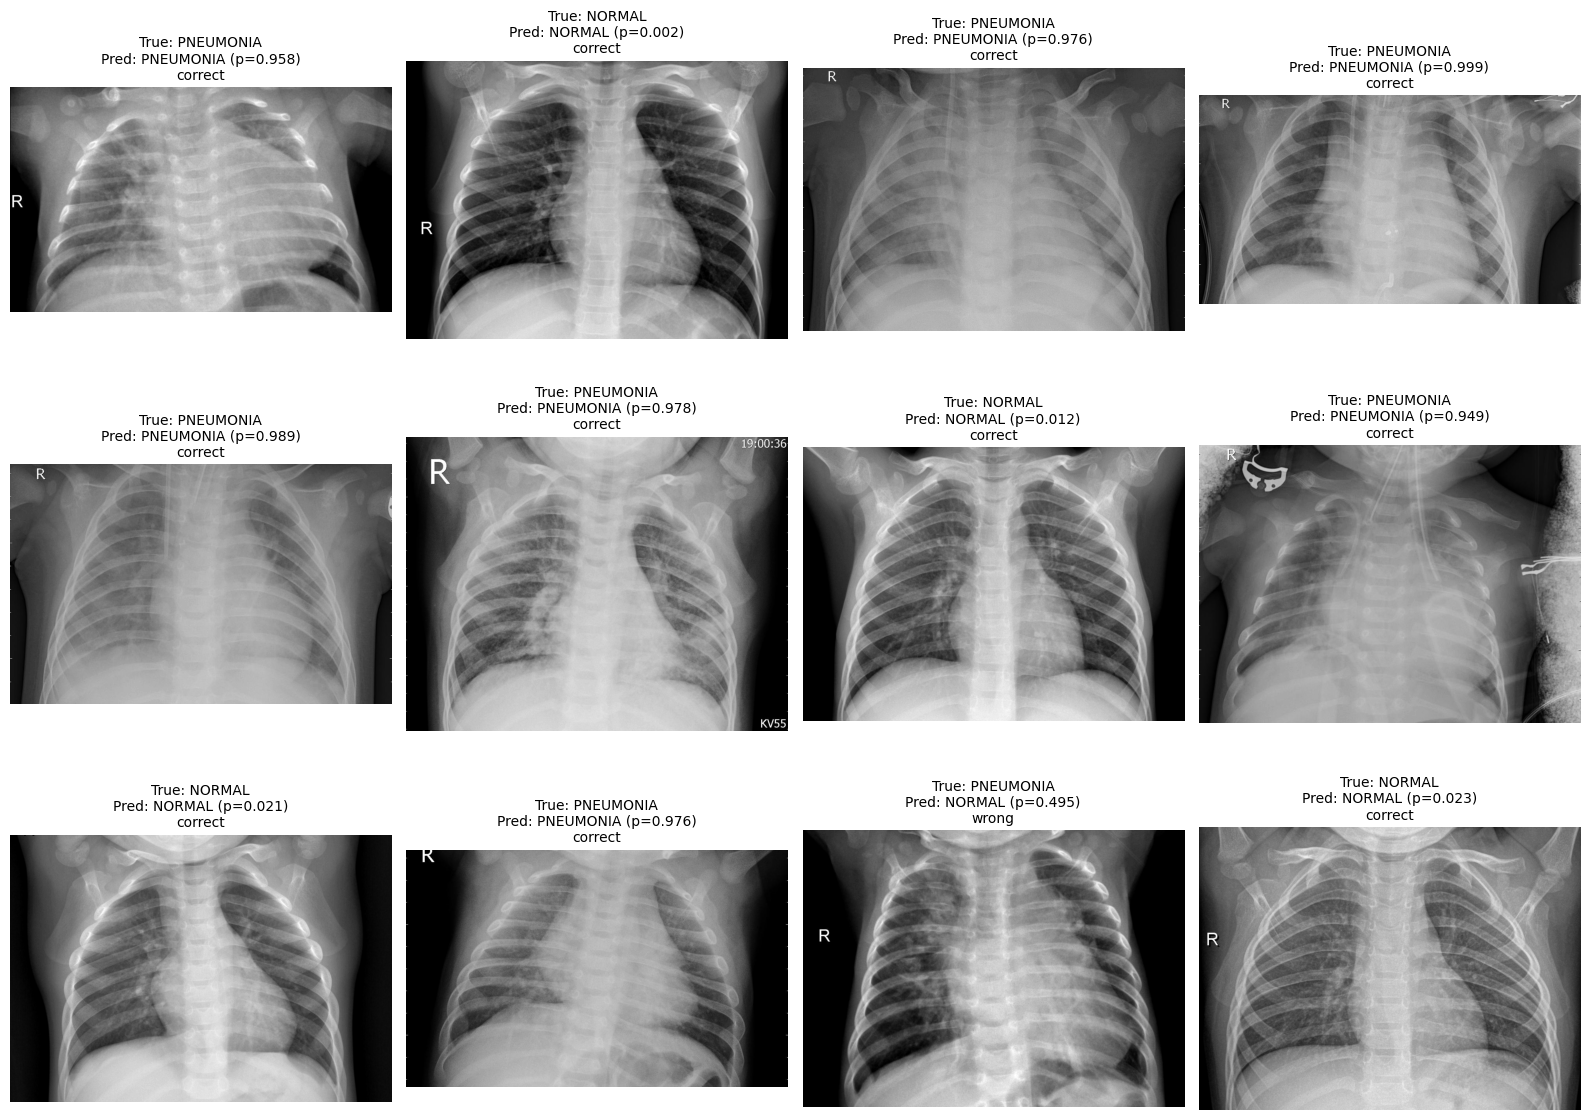

In [17]:
def show_predictions_grid(model, test_gen, n=12, threshold=0.5, seed=42):
    """
    Random minták a teszt halmazból: kép + true/pred + prob + helyes/hibás jelzés.
    Feltételezi, hogy test_gen shuffle=False.
    """
    rng = np.random.default_rng(seed)

    #predikcio a teljes teszthalmazra(egyszer)
    test_gen.reset()
    y_prob = model.predict(test_gen, verbose=0).ravel()
    y_true = test_gen.classes
    y_pred = (y_prob >= threshold).astype(int)

    #indexek kivalasztasa
    idxs = rng.choice(len(y_true), size=min(n, len(y_true)), replace=False)

    #osztalynevek
    idx_to_class = {v: k for k, v in test_gen.class_indices.items()}  # pl. {0:"NORMAL",1:"PNEUMONIA"}
    class_names = [idx_to_class[0], idx_to_class[1]]

    cols = 4
    rows = int(np.ceil(len(idxs) / cols))
    plt.figure(figsize=(cols * 4, rows * 4))

    for i, idx in enumerate(idxs, start=1):
        #kep betoltese fajlbol
        img_path = test_gen.filepaths[idx]
        img = plt.imread(img_path)

        true_label = y_true[idx]
        pred_label = y_pred[idx]
        prob = y_prob[idx]

        correct = (true_label == pred_label)
        title = (
            f"True: {class_names[true_label]}\n"
            f"Pred: {class_names[pred_label]} (p={prob:.3f})\n"
            f"{'correct' if correct else 'wrong'}"
        )

        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap="gray" if img.ndim == 2 else None)
        plt.axis("off")
        plt.title(title, fontsize=10)

    plt.tight_layout()
    plt.show()

#pelda futtatas
show_predictions_grid(model, test_gen, n=12, threshold=0.5, seed=42)

**“Legcsúnyább hibák” (amikben a modell nagyon magabiztos, mégis rossz)**

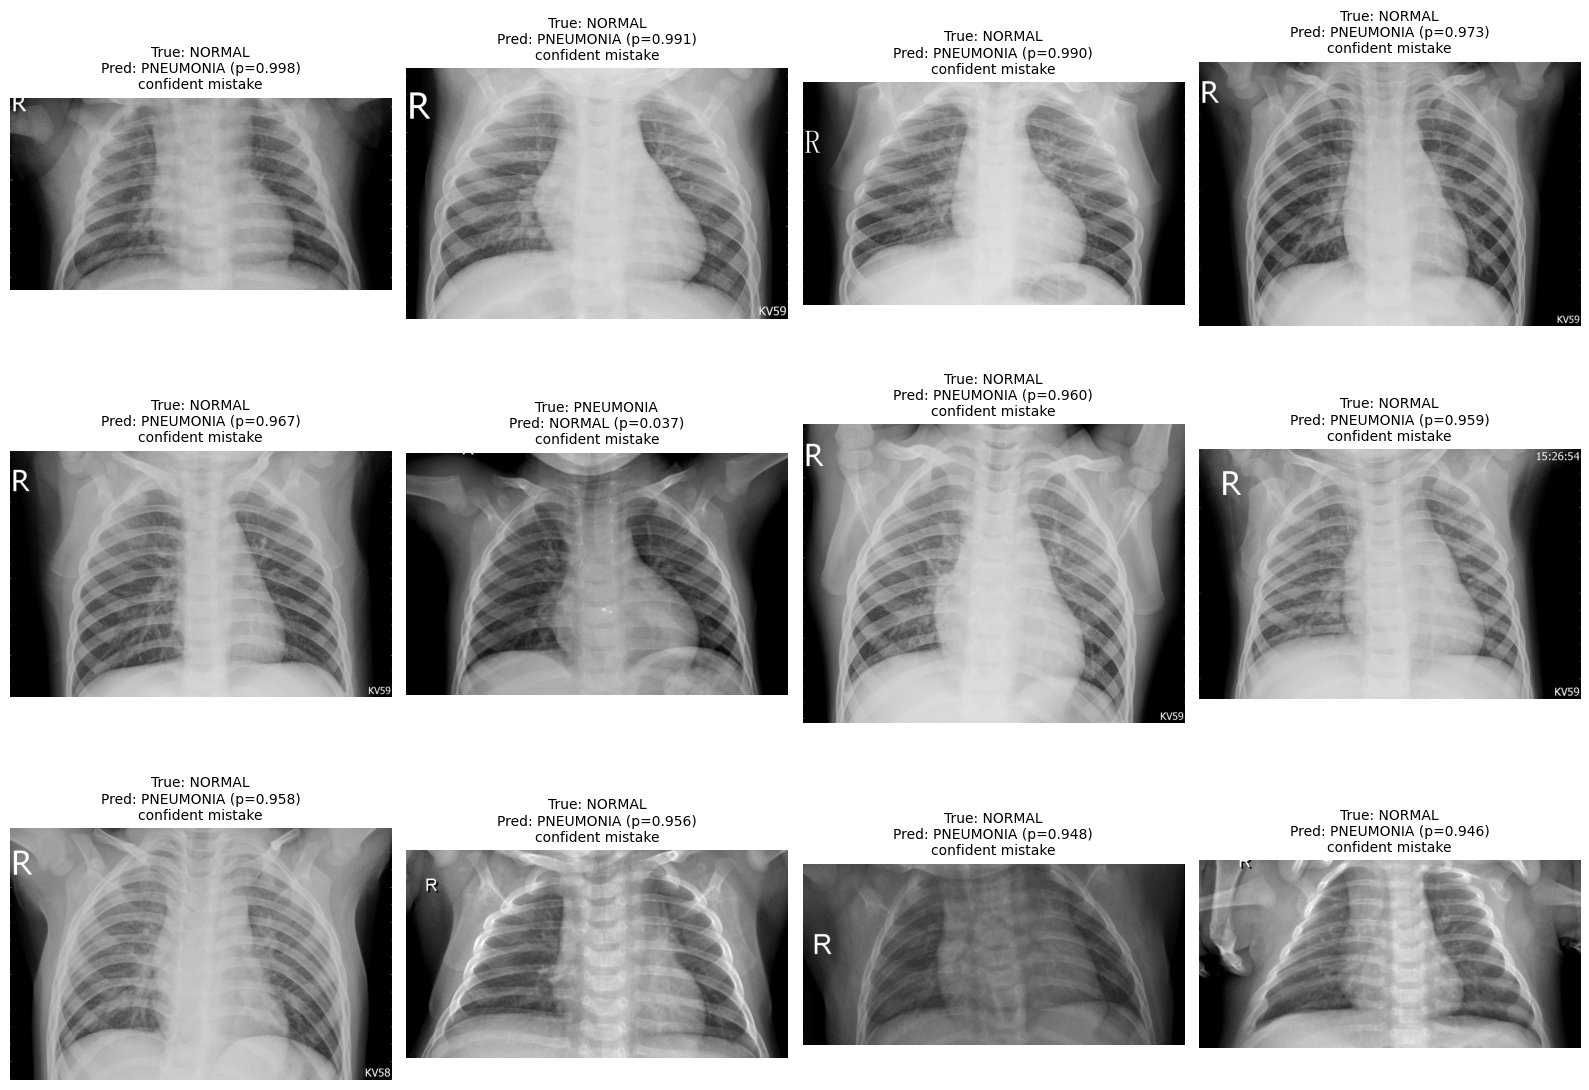

In [18]:
def show_top_mistakes(model, test_gen, k=12, threshold=0.5):
    """
    Megmutatja a k legmagabiztosabb tévedést a teszthalmazból.
    """
    test_gen.reset()
    y_prob = model.predict(test_gen, verbose=0).ravel()
    y_true = test_gen.classes
    y_pred = (y_prob >= threshold).astype(int)

    wrong = np.where(y_true != y_pred)[0]
    if len(wrong) == 0:
        print("Nincs tévesztés a teszthalmazon ezzel a threshold-dal.")
        return

    #"magabiztossag" = mennyire tavol van a 0.5-tol
    confidence = np.abs(y_prob[wrong] - threshold)
    top_wrong = wrong[np.argsort(-confidence)][:min(k, len(wrong))]

    idx_to_class = {v: k for k, v in test_gen.class_indices.items()}
    class_names = [idx_to_class[0], idx_to_class[1]]

    cols = 4
    rows = int(np.ceil(len(top_wrong) / cols))
    plt.figure(figsize=(cols * 4, rows * 4))

    for i, idx in enumerate(top_wrong, start=1):
        img_path = test_gen.filepaths[idx]
        img = plt.imread(img_path)

        true_label = y_true[idx]
        pred_label = y_pred[idx]
        prob = y_prob[idx]

        title = (
            f"True: {class_names[true_label]}\n"
            f"Pred: {class_names[pred_label]} (p={prob:.3f})\n"
            f"confident mistake"
        )

        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap="gray" if img.ndim == 2 else None)
        plt.axis("off")
        plt.title(title, fontsize=10)

    plt.tight_layout()
    plt.show()

#pelda futtatas:
show_top_mistakes(model, test_gen, k=12, threshold=0.5)


**Modell mentése**

In [13]:
final_model_path = os.path.join(MODEL_DIR, "densenet121_final.keras")
model.save(final_model_path)
print("Saved:", final_model_path)

Saved: /kaggle/working/models/densenet121_final.keras
